# Питер и волк: Реалистичная среда

В нашей ситуации Питер мог передвигаться почти без усталости и голода. В более реалистичном мире ему нужно время от времени отдыхать и питаться. Давайте сделаем наш мир более реалистичным, внедрив следующие правила:

1. При перемещении из одного места в другое Питер теряет **энергию** и набирает **усталость**.
2. Питер может восстановить энергию, съев яблоки.
3. Питер может избавиться от усталости, отдыхая под деревом или на траве (т.е. заходя на клетку с деревом или травой - зеленое поле).
4. Питеру нужно найти и убить волка.
5. Чтобы убить волка, Питер должен иметь определенный уровень энергии и усталости, иначе он проиграет битву.


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
import math
from rlboard import *

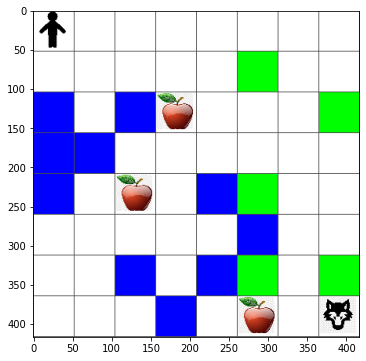

In [2]:
width, height = 8,8
m = Board(width,height)
m.randomize(seed=13)
m.plot()

In [3]:
actions = { "U" : (0,-1), "D" : (0,1), "L" : (-1,0), "R" : (1,0) }
action_idx = { a : i for i,a in enumerate(actions.keys()) }

## Определение состояния

В наших новых правилах игры нам нужно отслеживать энергию и усталость на каждом этапе игрового поля. Поэтому мы создадим объект `state`, который будет содержать всю необходимую информацию о текущем состоянии задачи, включая состояние игрового поля, текущие уровни энергии и усталости, а также возможность победить волка в конечном состоянии:


In [4]:
class state:
    def __init__(self,board,energy=10,fatigue=0,init=True):
        self.board = board
        self.energy = energy
        self.fatigue = fatigue
        self.dead = False
        if init:
            self.board.random_start()
        self.update()

    def at(self):
        return self.board.at()

    def update(self):
        if self.at() == Board.Cell.water:
            self.dead = True
            return
        if self.at() == Board.Cell.tree:
            self.fatigue = 0
        if self.at() == Board.Cell.apple:
            self.energy = 10

    def move(self,a):
        self.board.move(a)
        self.energy -= 1
        self.fatigue += 1
        self.update()

    def is_winning(self):
        return self.energy > self.fatigue

In [5]:
def random_policy(state):
    return random.choice(list(actions))

def walk(board,policy):
    n = 0 # number of steps
    s = state(board)
    while True:
        if s.at() == Board.Cell.wolf:
            if s.is_winning():
                return n # success!
            else:
                return -n # failure!
        if s.at() == Board.Cell.water:
            return 0 # died
        a = actions[policy(m)]
        s.move(a)
        n+=1

walk(m,random_policy)

0

In [6]:
def print_statistics(policy):
    s,w,n = 0,0,0
    for _ in range(100):
        z = walk(m,policy)
        if z<0:
            w+=1
        elif z==0:
            n+=1
        else:
            s+=1
    print(f"Killed by wolf = {w}, won: {s} times, drown: {n} times")

print_statistics(random_policy)

Killed by wolf = 5, won: 1 times, drown: 94 times


## Функция вознаграждения

### Введение
Функция вознаграждения играет ключевую роль в обучении с подкреплением. Она определяет, какие действия агенту следует считать успешными, а какие — нет. Правильное проектирование функции вознаграждения критически важно для достижения желаемого поведения.

### Основные принципы
- **Простота**: Функция вознаграждения должна быть максимально простой и понятной.
- **Согласованность**: Вознаграждение должно точно отражать цели задачи.
- **Избегайте нежелательных последствий**: Убедитесь, что функция вознаграждения не стимулирует нежелательное поведение.

### Пример
```python
def reward_function(state, action):
    if state == "goal_reached":
        return 10  # Вознаграждение за достижение цели
    elif action == "invalid":
        return -1  # Штраф за недопустимое действие
    else:
        return 0  # Нейтральное вознаграждение
```

### Советы
[!TIP] Начните с простой функции вознаграждения и постепенно усложняйте её, если это необходимо.

### Предупреждения
[!WARNING] Сложные функции вознаграждения могут привести к непредсказуемому поведению агента.

### Заключение
Функция вознаграждения — это основа успешного обучения агента. Потратьте время на её тщательное проектирование, чтобы обеспечить достижение желаемых результатов.


In [7]:
def reward(s):
    r = s.energy-s.fatigue
    if s.at()==Board.Cell.wolf:
        return 100 if s.is_winning() else -100
    if s.at()==Board.Cell.water:
        return -100
    return r

## Алгоритм Q-обучения

Сам алгоритм обучения остается практически неизменным, мы просто используем `state` вместо одной лишь позиции на доске.


In [8]:
Q = np.ones((width,height,len(actions)),dtype=np.float)*1.0/len(actions)

In [9]:
def probs(v,eps=1e-4):
    v = v-v.min()+eps
    v = v/v.sum()
    return v

In [10]:

from IPython.display import clear_output

lpath = []

for epoch in range(10000):
    clear_output(wait=True)
    print(f"Epoch = {epoch}",end='')

    # Pick initial point
    s = state(m)
    
    # Start travelling
    n=0
    cum_reward = 0
    while True:
        x,y = s.board.human
        v = probs(Q[x,y])
        while True:
            a = random.choices(list(actions),weights=v)[0]
            dpos = actions[a]
            if s.board.is_valid(s.board.move_pos(s.board.human,dpos)):
                break 
        s.move(dpos)
        r = reward(s)
        if abs(r)==100: # end of game
            print(f" {n} steps",end='\r')
            lpath.append(n)
            break
        alpha = np.exp(-n / 3000)
        gamma = 0.5
        ai = action_idx[a]
        Q[x,y,ai] = (1 - alpha) * Q[x,y,ai] + alpha * (r + gamma * Q[x+dpos[0], y+dpos[1]].max())
        n+=1

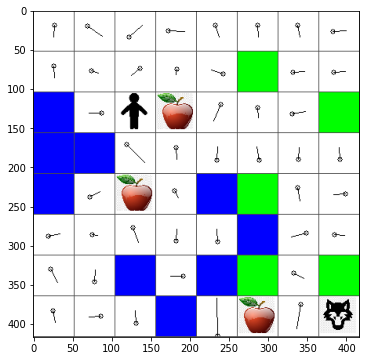

In [11]:
m.plot(Q)

## Результаты

Давайте посмотрим, удалось ли нам научить Питера бороться с волком!


In [12]:
def qpolicy(m):
        x,y = m.human
        v = probs(Q[x,y])
        a = random.choices(list(actions),weights=v)[0]
        return a

print_statistics(qpolicy)

Killed by wolf = 1, won: 9 times, drown: 90 times


Теперь мы видим гораздо меньше случаев утопления, но Питер все еще не всегда может убить волка. Попробуйте поэкспериментировать и посмотреть, сможете ли вы улучшить этот результат, изменяя гиперпараметры.


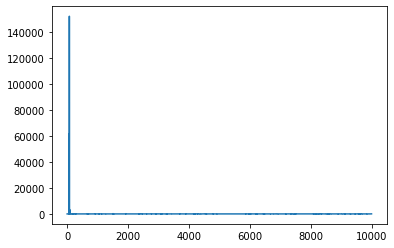

In [13]:
plt.plot(lpath)


---

**Отказ от ответственности**:  
Этот документ был переведен с помощью сервиса автоматического перевода [Co-op Translator](https://github.com/Azure/co-op-translator). Несмотря на наши усилия обеспечить точность, автоматические переводы могут содержать ошибки или неточности. Оригинальный документ на его родном языке следует считать авторитетным источником. Для получения критически важной информации рекомендуется профессиональный перевод человеком. Мы не несем ответственности за любые недоразумения или неправильные интерпретации, возникшие в результате использования данного перевода.
